In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [52]:
morph_rare = ['4139265.3','4139265.4','4139265.5']
morph_familiar = ['4222153.2','4222154.1','4222153.1']

In [53]:

def U_list_maker(mlist):
    U_list = []
    morphs = np.linspace(0,1,num=11)[1:]
    #effMorph_dig = np.digitize(effMorph,morphs,right=True)
    for mouse in mlist: #['4139265.3','4139265.4','4139265.5']:
        df_mouse = df[df['MouseName'].str.match(mouse)]

        for mat_ind,sess_ind in enumerate(np.arange(5,df_mouse.shape[0])):
            print("session ind",sess_ind)
            sess = df_mouse.iloc[sess_ind]

            VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
            trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


            effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
            effMorph= (effMorph-np.amin(effMorph))/(np.amax(effMorph)-np.amin(effMorph))
            msort = np.argsort(effMorph)
            effMorph=effMorph[msort]
            effMorph_dig = np.digitize(effMorph,morphs,right=True)
            #print(effMorph_dig)
            S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10)
            S_trial_mat=S_trial_mat[msort,:,:]
            S_tm = S_trial_mat.reshape([S_trial_mat.shape[0],-1])
            #S_tm = sp.stats.zscore(S_tm,axis=1)
            S_tm/=np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]
            SM=np.matmul(S_tm,S_tm.T)
            SM[np.diag_indices(S_tm.shape[0])]=np.nan

            U_tmp = np.zeros([morphs.shape[0],morphs.shape[0]])

            for row,morph_r in enumerate(range(np.amax(effMorph_dig)+1)):
                for col, morph_c in enumerate(range(np.amax(effMorph_dig)+1)):
                    mask = np.matmul((effMorph_dig==morph_r).reshape([-1,1]),(effMorph_dig==morph_c).reshape([1,-1]))

                    U_tmp[row,col] = np.nanmean( SM[mask].ravel())

            if mat_ind == 0:

                U = np.zeros([U_tmp.shape[0],U_tmp.shape[1],df_mouse.shape[0]-5])

            U[:,:,mat_ind]=U_tmp


        U_list.append(U)
        
    return U_list

In [54]:
#U_rare = U_list_maker(morph_rare)
U_fam = U_list_maker(morph_familiar)

session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
frame diff 0
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
frame diff 0
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
frame diff 0
session ind 5
num aberrant ttls 0.0
28890 (28890,) (28890, 21) 94524
frame diff 0
session ind 6
num aberrant ttls 0.0
31805 (31805,) (31805, 21) 105737
frame diff 0
session ind 7
num aberrant ttls 0.0
33473 (33473,) (33473, 21) 110483
frame diff 0
session ind 8
num aberrant ttls 0.0
34639 (34639,) (34639, 21) 115107
frame diff 0
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
frame diff 0
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
frame diff 0


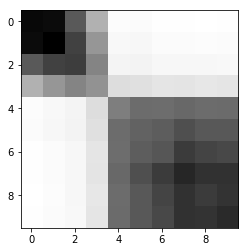

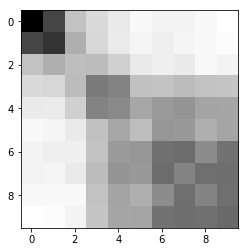

In [63]:

def U_mean_mat(U_list):
    U_mean = np.zeros(U_list[0].shape[:-1])
    for mouse in range(len(U_list)):
        U_tmp = U_list[mouse]
        minn,maxx = np.amin(U_tmp),np.amax(U_tmp)
        U_tmp  = (U_tmp-minn)/(maxx-minn)
#         U_tmp/=np.amax(U_tmp)
        U_mean+=U_tmp.mean(axis=-1)
        #U_mean+=U_list[mouse].mean(axis=-1)
    U_mean/=mouse
    f_U,ax_U = plt.subplots()
    ax_U.imshow(U_mean,cmap='Greys')
    return f_U,ax_U
# f_U.savefig("G:\\My Drive\\LabEvening_2019\\MorphSimMat_mean_MorphNaive.pdf",format='pdf')

f_rare,ax_rare = U_mean_mat(U_rare)
f_rare.savefig("G:\\My Drive\\LabEvening_2019\\trialSM_binned_MorphRare.svg",format='svg')

f_fam, ax_fam = U_mean_mat(U_fam)
f_fam.savefig("G:\\My Drive\\LabEvening_2019\\trialSM_binned_MorphFam.svg",format='svg')

In [56]:
def U_mouse_plots(U_list,cmap='copper'):
    cm = plt.cm.get_cmap(cmap)
    f,ax = plt.subplots(2,2,figsize=[8,10])
    for mouse in range(len(U_list)):
        color = mouse/np.float(len(U_list))
        U_tmp = U_list[mouse]
        U_mean = U_tmp.mean(axis=-1)
        U_sem = sp.stats.sem(U_tmp,axis=-1)

        minn,maxx = np.amin(U_mean,axis=1)[:,np.newaxis],np.amax(U_mean,axis=1)[:,np.newaxis]
#         print(minn.shape)
#         U_norm = U_tmp/np.amax(U_mean,axis=1)[:,np.newaxis]
        U_n_mu  = (U_mean-minn)/(maxx-minn)
#         print(U_mean,U_n_mu)
        U_n_sem = U_sem/(maxx-minn)
    
    
        dm = 1/U_tmp.shape[0]
        morphs = np.arange(dm-dm/2,1,dm)
        for ind,m in enumerate([0,-1]): #range(morphs.shape[0]):
    #         mask = np.ones(morphs.shape)
    #         mask[m]=0
    #         mask = mask>0
            
            ax[ind,0].fill_between(morphs,U_mean[m,:]+U_sem[m,:],y2=U_mean[m,:]-U_sem[m,:],color=cm(color),alpha=.5)
            ax[ind,0].set_ylim([.30,1])
            ax[ind,0].set_xlim([0,1])
            
            ax[ind,1].fill_between(morphs,U_n_mu[m,:]+U_n_sem[m,:],y2=U_n_mu[m,:]-U_n_sem[m,:],color=cm(color),alpha=.5)
            ax[ind,1].set_ylim([-.2,1.2])
            ax[ind,1].set_xlim([0,1])
    return f,ax

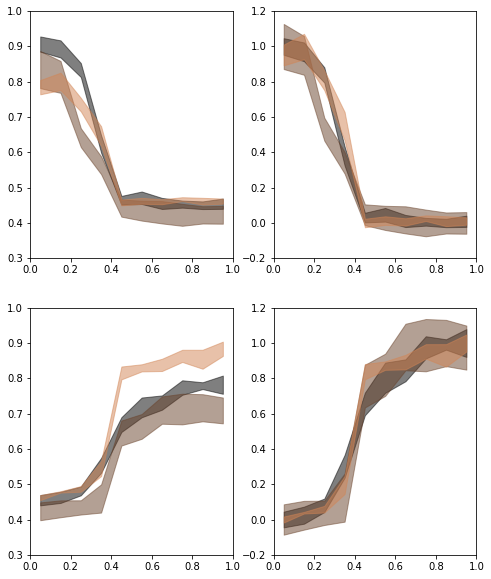

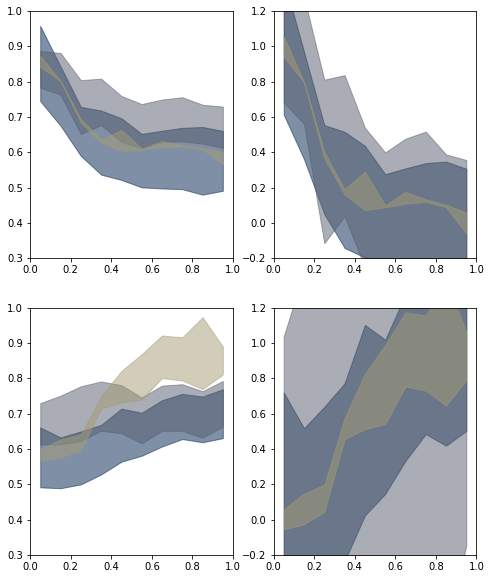

In [64]:
f_rare,ax_rare=U_mouse_plots(U_rare,cmap='copper')
f_fam,ax_fam = U_mouse_plots(U_fam,cmap='cividis')
f_rare.savefig("G:\\My Drive\\LabEvening_2019\\trialSM_rows_MorphRare.svg",format='svg')
f_fam.savefig("G:\\My Drive\\LabEvening_2019\\trialSM_rows_MorphFamiliar.svg",format='svg')

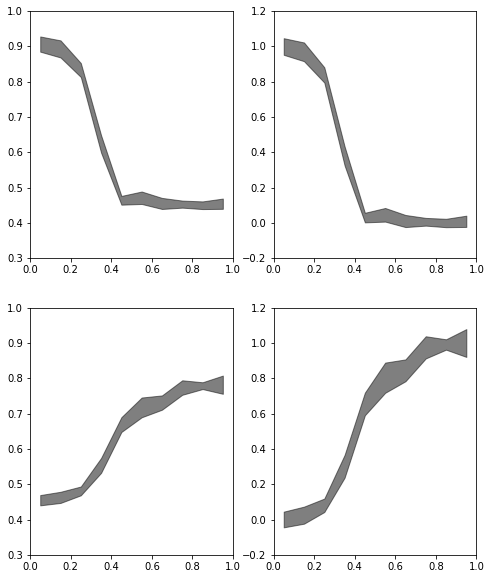

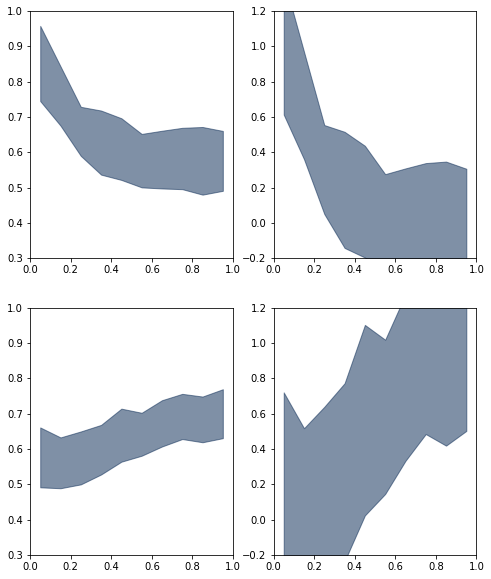

In [65]:
f_rare,ax_rare=U_mouse_plots(U_rare[:1],cmap='copper')
f_fam,ax_fam = U_mouse_plots(U_fam[:1],cmap='cividis')
f_rare.savefig("G:\\My Drive\\LabEvening_2019\\trialSM_rows_MorphRare_1mouse.svg",format='svg')
f_fam.savefig("G:\\My Drive\\LabEvening_2019\\trialSM_rows_MorphFamiliar_1mouse.svg",format='svg')